# Introduction

In this notebook, I will be including all the necessary steps and I will be writing down my thought process and I might include some screenshots as well and places where I got stuck and also how I ended up solving them.

*PS :* Data cleaning and scraping is not always pretty and there are many different ways to get to the result you want. This is a strategy that I followed. Also, always mkae sure to Google and look at Stackoverflow if you do get stuck. There is nothing wrong in looking for answers there. 

Inspired by : [Keith Galli](https://www.youtube.com/channel/UCq6XkhO5SZ66N04IcPbqNcw). 

### Importing the necessary libraries

In [4]:
import pandas as pd #For Data cleaning and processing
from bs4 import BeautifulSoup as bs #To scrape the data
import requests #To connect to the webpages directly

In [5]:
response = requests.get('https://en.wikipedia.org/wiki/Toy_Story_3')
soup = bs(response.text)

#print(soup.prettify())

We will first look at a single movie, build up a method and process of getting data from a single page, then get a list of urls and get data from those url and store the data somewhere. 

If you take a look at the [Toy Story 3](https://en.wikipedia.org/wiki/Toy_Story_3) Wikipedia page, or any other Wikipedia page, there will be an info box table on the right side which contains a lot of useful information. 

#### Getting the Info Box

There are many ways to get to the info box using the HTML. The info box is always the first table tag on the wikipedia page. So you could do one of two things: 

- use `find('table')` to get the first table which will be the info box itself OR 
- look at the class of the table then use `find(class_ = 'some_class')` to get the corresponding table i.e. the info box. 

In [6]:
info_box = soup.find(class_='infobox vevent')

A table consists of `th` tags for table headers, `tr` tags for table rows and `td` tags for table data. You can think of it as headers being columns and table rows as rows making a table with td being the actual data records in it. 

Hence, once we look at the HTML source, we see that the table tag is made up of multiple table rows which are its child. We can use `find_all('tr')` to get a list (BS4 ResultSet) of table rows. 

In [9]:
info_rows = info_box.find_all('tr')

# for row in info_rows:
#     print(row.prettify())

<tr>
 <th class="summary" colspan="2" style="text-align:center;font-size:125%;font-weight:bold;font-size:110%;font-style:italic;">
  Toy Story 3
 </th>
</tr>

<tr>
 <td colspan="2" style="text-align:center">
  <a class="image" href="/wiki/File:Toy_Story_3_poster.jpg" title="All of the toys packed close together, holding up a large numeral '3', with Buzz, who is putting a friendly arm around Woody's shoulder, and Woody holding the top of the 3.">
   <img alt="All of the toys packed close together, holding up a large numeral '3', with Buzz, who is putting a friendly arm around Woody's shoulder, and Woody holding the top of the 3." class="thumbborder" data-file-height="326" data-file-width="220" decoding="async" height="326" src="//upload.wikimedia.org/wikipedia/en/6/69/Toy_Story_3_poster.jpg" width="220"/>
  </a>
  <div style="font-size:95%;padding:0.35em 0.35em 0.25em;line-height:1.25em;">
   Theatrical release poster
  </div>
 </td>
</tr>

<tr>
 <th scope="row" style="white-space:nowra

Looking at the structure of the `<tr>` tags, we can see a pattern that all the `<th>` tags under `<tr>` can be thought of as keys of a python dictionary and the values would be the data in `<td>` tags. See the screenshot below for understanding : 

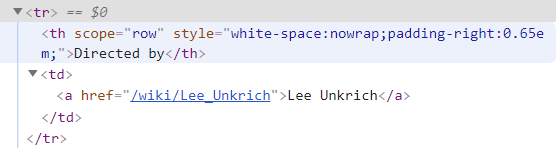

Hence, we can loop over the info_rows ResultSet to get the data for all the rows and store it in a python dictionary for now. 

In [11]:
movie_info = {}
for index, row in enumerate(info_rows):
    if index == 0:
        movie_info['title'] = row.find('th').get_text(' ', strip = True)
    elif index == 1:
        continue
    else: 
        keys = row.find('th').get_text(' ', strip = True)
        values = row.find('td').get_text(' ', strip = True)
        movie_info[keys] = values
print (movie_info)

{'title': 'Toy Story 3', 'Directed by': 'Lee Unkrich', 'Produced by': 'Darla K. Anderson', 'Screenplay by': 'Michael Arndt', 'Story by': 'John Lasseter Andrew Stanton Lee Unkrich', 'Starring': 'Tom Hanks Tim Allen Joan Cusack Don Rickles Wallace Shawn John Ratzenberger Estelle Harris Blake Clark Jeff Pidgeon Ned Beatty Michael Keaton Jodi Benson John Morris', 'Music by': 'Randy Newman', 'Cinematography': 'Jeremy Lasky Kim White', 'Edited by': 'Ken Schretzmann', 'Production company': 'Walt Disney Pictures Pixar Animation Studios', 'Distributed by': 'Walt Disney Studios Motion Pictures', 'Release date': 'June\xa012,\xa02010 ( 2010-06-12 ) ( Taormina Film Fest ) June\xa018,\xa02010 ( 2010-06-18 ) (United States)', 'Running time': '103 minutes [1]', 'Country': 'United States', 'Language': 'English', 'Budget': '$200\xa0million [1]', 'Box office': '$1.067\xa0billion [1]'}


In the above code, we need to enumerate and add an index to the info rows ResultSet because the 2nd `<tr>` tag i.e. the first index contains image which we don't need hence we skip that. 

One issue I could straight away make out was the weird `\xa0` string which we will remove using string replacement. There is another issue that there are multiple values which come under the `<li>` in *td* which need to be stored as a list rather than some space seperated strings. 

Hence, we can make a new function to check if there is an `<li>` and if there is then using list comprehension return a list of those, otherwise just return the normal string. 

In [14]:
def get_content_values(row):
    if row.find('li'):
        return [li.get_text(' ', strip = True).replace('\xa0', '') for li in row.find_all('li')]
    else:
        return row.find('td').get_text(' ', strip = True).replace('\xa0', '')
    
movie_info = {}
for index, row in enumerate(info_rows):
    if index == 0:
        movie_info['title'] = row.find('th').get_text(' ', strip = True)
    elif index == 1:
        continue
    else: 
        keys = row.find('th').get_text(' ', strip = True)
        values = get_content_values(row)
        movie_info[keys] = values
        
movie_info

{'title': 'Toy Story 3',
 'Directed by': 'Lee Unkrich',
 'Produced by': 'Darla K. Anderson',
 'Screenplay by': 'Michael Arndt',
 'Story by': ['John Lasseter', 'Andrew Stanton', 'Lee Unkrich'],
 'Starring': ['Tom Hanks',
  'Tim Allen',
  'Joan Cusack',
  'Don Rickles',
  'Wallace Shawn',
  'John Ratzenberger',
  'Estelle Harris',
  'Blake Clark',
  'Jeff Pidgeon',
  'Ned Beatty',
  'Michael Keaton',
  'Jodi Benson',
  'John Morris'],
 'Music by': 'Randy Newman',
 'Cinematography': ['Jeremy Lasky', 'Kim White'],
 'Edited by': 'Ken Schretzmann',
 'Production company': ['Walt Disney Pictures', 'Pixar Animation Studios'],
 'Distributed by': 'Walt Disney Studios Motion Pictures',
 'Release date': ['June12,2010 ( 2010-06-12 ) ( Taormina Film Fest )',
  'June18,2010 ( 2010-06-18 ) (United States)'],
 'Running time': '103 minutes [1]',
 'Country': 'United States',
 'Language': 'English',
 'Budget': '$200million [1]',
 'Box office': '$1.067billion [1]'}

## Getting list of all Disney Movies

Now that we have made a workflow for one movie, we can do the same for all the disney movies. But, we need to get the url to the movies which we will get by scraping [link](https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films). 

The link mentioned above consists of all the Disney movie names and their wikipedia links stored in tables for all decades starting from 1930's. 

We will work with a single table then work on scraping all the tables to get links for all Disney Movies and ultimately there info box data. 

In [15]:
response = requests.get('https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films')
soup = bs(response.text)

We will use the `.select()` method to work with the table. Since the table class is space seperated, it means that there are multiple classes within the `<table>` and hence we will use `.select()` to match any of the classes of it. 

In [21]:
movies = soup.select('.wikitable.sortable i a')
#type(movies)
print(movies[0].prettify())

<a href="/wiki/Academy_Award_Review_of_Walt_Disney_Cartoons" title="Academy Award Review of Walt Disney Cartoons">
 Academy Award Review of Walt Disney Cartoons
</a>


Now we will apply the above method to get one movie and its link to scrape all the URLs and get info box data for it.

I have just copied the `get_content_values` function from the above mentioned cell. Also, the `clean_tags` function just looks for `<span>` and `<sup>` tags and will just remove them. This is needed otherwise all the citation references will show up which is not needed. Hence, using this function, we can remove <sup>[1]</sup> <sup>[2]</sup> etc. 

Also, in the `get_info_box` function, I will pass a URL after scraping it and get an info box for it.

In [45]:
def get_content_values(row):
    if row.find('li'):
        return [li.get_text(' ', strip = True).replace('\xa0', '') for li in row.find_all('li')]
    else:
        return row.find('td').get_text(' ', strip = True).replace('\xa0', '')

def clean_tags(soup):
    for tag in soup.find_all(['sup', 'span']):
        tag.decompose()

def get_info_box(url):
    
    response = requests.get(url)
    soup = bs(response.text)

    info_box = soup.find(class_='infobox vevent')
    info_rows = info_box.find_all('tr')

    clean_tags(soup)
    
    movie_info = {}
    for index, row in enumerate(info_rows):
        if index == 0:
            movie_info['title'] = row.find('th').get_text(' ', strip = True)
        elif index == 1:
            continue
        else: 
            keys = row.find('th').get_text(' ', strip = True)
            values = get_content_values(row)
            movie_info[keys] = values
    return movie_info

Now, it is time to apply the functions above to all the URLs. 

I will visit the List of Walt Disney list, scrape the links on all tables and then add the data I get which will be a dictionary for each movie to the `movie_list`. I have used the time module to sleep for 1 second after every URL visited to avoid myself from being blocked by wikipedia.

Try and except is needed because sometimes a link may be broken or there might be some other error, hence it will help me handle exceptions. In this case, I got less than 8 movies with errors so I will just ignore them. 

In [50]:
import time

response = requests.get('https://en.wikipedia.org/wiki/List_of_Walt_Disney_Pictures_films')
soup = bs(response.text)

movies = soup.select('.wikitable.sortable i a')
movie_list = []
base_url = 'https://en.wikipedia.org/' 

for index, movie in enumerate(movies):
    try:
        link = movie['href']
        full_url = base_url + link
        title = movie['title']
        movie_list.append(get_info_box(full_url))
        print('sleep for a second')
        time.sleep(1)
    except Exception as e:
        print(movie.get_text())
        print(e)

sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
Zorro the Avenger
'NoneType' object has no attribute 'get_text'
sleep for a second
sleep for a second
sleep for a second
sleep for a second
The Sign of Zorro
'NoneType' object has no 

sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
Luca
'NoneType' object has no attribute 'find_all'
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second
sleep for a second


In [60]:
len(movie_list)

432

In [55]:
df = pd.DataFrame(movie_list)
df.head()

,title,Production company,Release date,Running time,Country,Language,Box office,Directed by,Produced by,Written by,...,Starring,Music by,Distributed by,Budget,Story by,Narrated by,Cinematography,Edited by,Screenplay by,Production companies
0,Academy Award Review of,Walt Disney Productions,"[May19,1937]",41 minutes (74 minutes 1966 release),United States,English,$45.472,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Snow White and the Seven Dwarfs,Walt Disney Productions,"[December21,1937 ( Carthay Circle Theatre , Lo...",83 minutes,United States,English,$418 million,"[David Hand (supervising), William Cottrell, W...",Walt Disney,"[Ted Sears, Richard Creedon, Otto Englander, D...",...,"[Adriana Caselotti, Lucille La Verne, Harry St...","[Frank Churchill, Paul Smith, Leigh Harline]",RKO Radio Pictures,$1.49 million,NaN,NaN,NaN,NaN,NaN,NaN
2,Pinocchio,Walt Disney Productions,"[February7,1940 ( Center Theatre ), February23...",88 minutes,United States,English,$164million,"[Ben Sharpsteen, Hamilton Luske, Bill Roberts,...",Walt Disney,NaN,...,"[Cliff Edwards, Dickie Jones, Christian Rub, M...","[Leigh Harline, Paul J. Smith]",RKO Radio Pictures,$2.6 million,"[Ted Sears, Otto Englander, Webb Smith, Willia...",NaN,NaN,NaN,NaN,NaN
3,Fantasia,Walt Disney Productions,"[November13,1940]",126 minutes,United States,English,$76.4–$83.3 million,"[Samuel Armstrong, James Algar, Bill Roberts, ...","[Walt Disney, Ben Sharpsteen]",NaN,...,"[Leopold Stokowski, Deems Taylor]",See program,"[Walt Disney Productions, RKO Radio Pictures]",$2.28 million,"[Joe Grant, Dick Huemer]",Deems Taylor,James Wong Howe,NaN,NaN,NaN
4,The Reluctant Dragon,Walt Disney Productions,"[June20,1941]",74 minutes,United States,English,"$960,000 (worldwide rentals)",Alfred Werker (live action) Hamilton Luske (an...,Walt Disney,Live-action: Ted Sears Al Perkins Larry Clemmo...,...,Robert Benchley Frances Gifford Buddy Pepper N...,Frank Churchill Larry Morey,RKO Radio Pictures,"$600,000",NaN,NaN,Bert Giennon,Paul Weatherwax,NaN,NaN


In [64]:
import json
def save_data(file, data):
    with open(file, 'w', encoding = 'utf-8') as f:
        json.dump(data, f, ensure_ascii = False, indent = 2)
        
def load_data(file):
    with open(file, 'r', encoding = 'utf-8') as f:
        return json.load(f)

In [62]:
save_data('disney_dataset.json', movie_list)

In [65]:
load_data('disney_dataset.json')

[{'title': 'Academy Award Review of',
  'Production company': 'Walt Disney Productions',
  'Release date': ['May19,1937'],
  'Running time': '41 minutes (74 minutes 1966 release)',
  'Country': 'United States',
  'Language': 'English',
  'Box office': '$45.472'},
 {'title': 'Snow White and the Seven Dwarfs',
  'Directed by': ['David Hand (supervising)',
   'William Cottrell',
   'Wilfred Jackson',
   'Larry Morey',
   'Perce Pearce',
   'Ben Sharpsteen'],
  'Produced by': 'Walt Disney',
  'Written by': ['Ted Sears',
   'Richard Creedon',
   'Otto Englander',
   'Dick Rickard',
   'Earl Hurd',
   'Merrill De Maris',
   'Dorothy Ann Blank',
   'Webb Smith'],
  'Based on': 'Snow White by The Brothers Grimm',
  'Starring': ['Adriana Caselotti',
   'Lucille La Verne',
   'Harry Stockwell',
   'Roy Atwell',
   'Pinto Colvig',
   'Otis Harlan',
   'Scotty Mattraw',
   'Billy Gilbert',
   'Eddie Collins',
   'Moroni Olsen',
   'Stuart Buchanan'],
  'Music by': ['Frank Churchill', 'Paul Smith',

# Cleaning Tasks